In [2]:
import numpy as np 
def low_elevation_delay_model(elevation_angle, met_data, freq):
    """
    小仰角大气延迟模型
    
    参数:
    elevation_angle: 仰角(度，≤10°)
    met_data: 气象数据
    freq: 观测频率(GHz)
    """
    # 1. 改进的投影函数
    def improved_mapping_function(elev):
        # 使用更精确的NMF(Niell Mapping Function)或VMF(Vienna Mapping Function)
        a = 0.0012769
        b = 0.0029024
        c = 0.0062106
        
        sin_elev = np.sin(np.radians(elev))
        return (1 + a/(1 + b/(1 + c)))/(sin_elev + a/(sin_elev + b/(sin_elev + c)))
    
    # 2. 考虑大气弯曲效应
    def ray_bending_correction(elev):
        # 射线弯曲修正
        return 0.0031 * np.tan(np.radians(90 - elev))
    
    # 3. 计算基本延迟
    zenith_delay = calculate_zenith_delay(met_data)
    mapping = improved_mapping_function(elevation_angle)
    bending = ray_bending_correction(elevation_angle)
    
    # 4. 添加额外修正项
    total_delay = zenith_delay * mapping + bending
    
    return total_delay

def atmospheric_layers():
    """
    定义大气层结构，返回高度、压强、温度和湿度数据
    返回: (heights, pressures, temperatures, humidities)
    """
    # 定义高度层（从地面到10km，每100m一层）
    heights = np.arange(0, 10000, 100)  # 米
    
    # 初始条件
    T0 = 288.15  # 地面温度(K)
    P0 = 1013.25  # 地面气压(hPa)
    H0 = 0.7  # 地面相对湿度
    
    # 使用标准大气模型计算各层参数
    temperatures = T0 - 0.0065 * heights  # 温度随高度变化
    pressures = P0 * np.exp(-0.0342 * heights/1000)  # 气压随高度变化
    humidities = H0 * np.exp(-heights/2000)  # 湿度随高度指数衰减
    
    return heights, pressures, temperatures, humidities

def calculate_zenith_delay(met_data):
    """计算天顶延迟的改进版本"""
    # 1. 分层大气模型
    heights, pressures, temperatures, humidities = atmospheric_layers()
    
    # 2. 考虑温度梯度
    def temperature_gradient(height):
        T0 = met_data['surface_temperature']
        lapse_rate = -0.0065  # K/m
        return T0 + lapse_rate * height
    
    # 3. 考虑压力变化
    def pressure_profile(height):
        P0 = met_data['surface_pressure']
        return P0 * np.exp(-0.0342 * height)
    
    # 积分计算总延迟
    total_delay = 0
    for i in range(len(heights)):
        T = temperature_gradient(heights[i])
        P = pressure_profile(heights[i])
        # 简化的延迟计算公式
        layer_delay = 77.6 * (P / T) * 0.1  # 0.1是层厚度(100m)转换为km
        total_delay += layer_delay
    
    return total_delay
def evaluate_model_performance():
    """评估模型性能"""
    # 测试案例
    test_conditions = [
        {'elevation': 8, 'temperature': 288.15, 'pressure': 1013.25},
        {'elevation': 5, 'temperature': 288.15, 'pressure': 1013.25},
        {'elevation': 3, 'temperature': 288.15, 'pressure': 1013.25}
    ]
    
    for condition in test_conditions:
        delay = low_elevation_delay_model(
            condition['elevation'],
            {'surface_temperature': condition['temperature'],'surface_pressure': condition['pressure']},
            20  # GHz
        )
        print(f"仰角 {condition['elevation']}°: 延迟 = {delay:.3f} ns")
        
if __name__ == "__main__":
    evaluate_model_performance()

仰角 8°: 延迟 = 191.929 ns
仰角 5°: 延迟 = 288.415 ns
仰角 3°: 延迟 = 435.546 ns


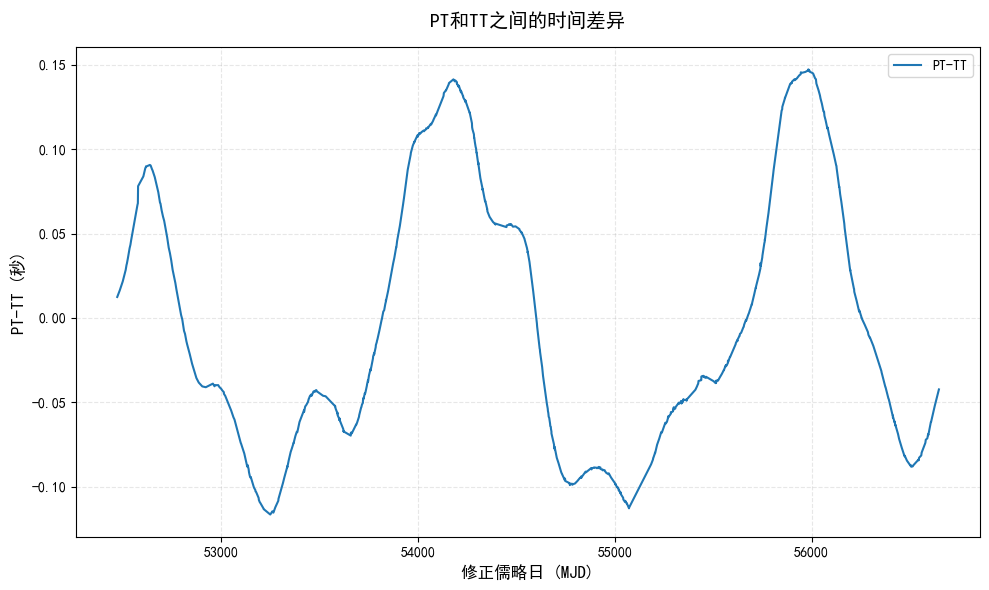

In [15]:

# ——————————————————————————
# 第一部分：原始数据可视化
# ——————————————————————————

# 创建数据可视化图表
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


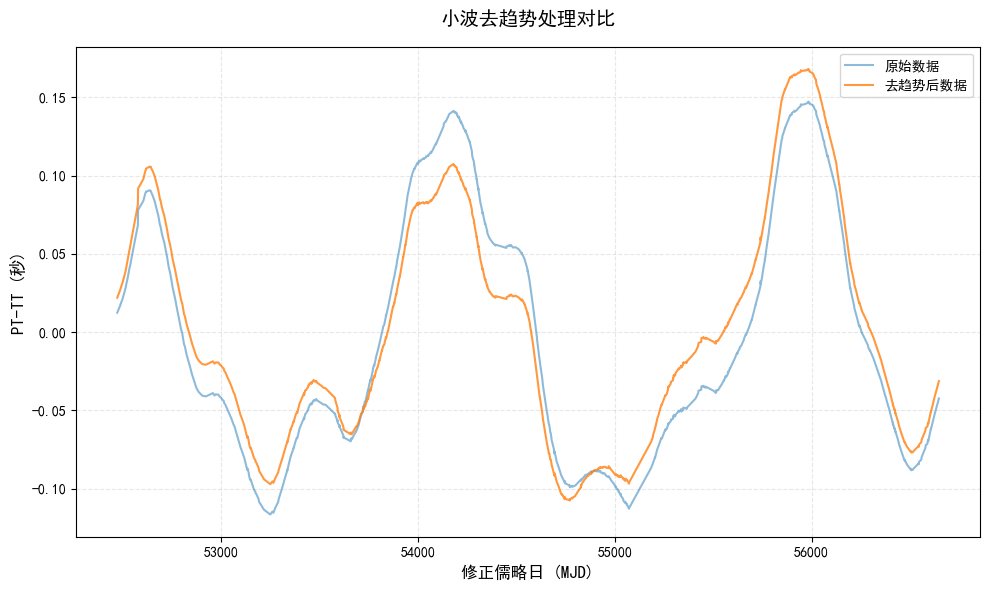

In [17]:
# ——————————————————————————
# 第二部分：小波去趋势处理
# ——————————————————————————

# 使用小波变换进行数据去趋势
def detrend_wavelet(data, wavelet='db8', level=8):
    # 确保数据长度满足小波变换要求
    coeffs = pywt.wavedec(data, wavelet, level=level)
    coeffs[0][:] = 0  # 移除最低频成分（趋势）
    detrended = pywt.waverec(coeffs, wavelet)
    # 确保输出长度与输入相同
    return detrended[:len(data)]

# 应用小波去趋势
detrended_residuals = detrend_wavelet(residuals)

# 可视化去趋势结果
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='原始数据', alpha=0.5)
plt.plot(time[:len(detrended_residuals)], detrended_residuals, label='去趋势后数据', alpha=0.8)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('小波去趋势处理对比', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()


In [1]:

# ——————————————————————————
# 第五部分：结果可视化与评估
# ——————————————————————————

# 计算最终拟合结果
psd_fitted = complex_power_spectral_density(frequencies, *params)

# 绘制拟合结果
plt.figure(figsize=(10, 6))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, psd_fitted, label="拟合PSD", color="red", linestyle="--")
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("改进的复合噪声模型拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

# 计算改进的R²
def calculate_improved_r_squared(y_true, y_pred):
    """计算加权对数空间中的R²值"""
    y_true_log = np.log10(y_true)
    y_pred_log = np.log10(y_pred)
    weights = 1 / np.log10(frequencies)  # 对低频部分给予更高权重
    weights = weights / np.sum(weights)
    
    residuals = (y_true_log - y_pred_log) * weights
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum(((y_true_log - np.mean(y_true_log)) * weights)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

# 计算并输出改进后的R²
r_squared = calculate_improved_r_squared(psd_values, psd_fitted)
print(f"\n改进后的模型拟合结果：")
print(f"P0 = {params[0]:.2e}, fc1 = {params[1]:.2e}, q1 = {params[2]:.2f}")
print(f"fc2 = {params[3]:.2e}, q2 = {params[4]:.2f}")
print(f"alpha = {params[5]:.2e}, beta = {params[6]:.2f}")
print(f"模型拟合度 (R²): {r_squared:.4f}")

if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要继续优化。")

NameError: name 'complex_power_spectral_density' is not defined

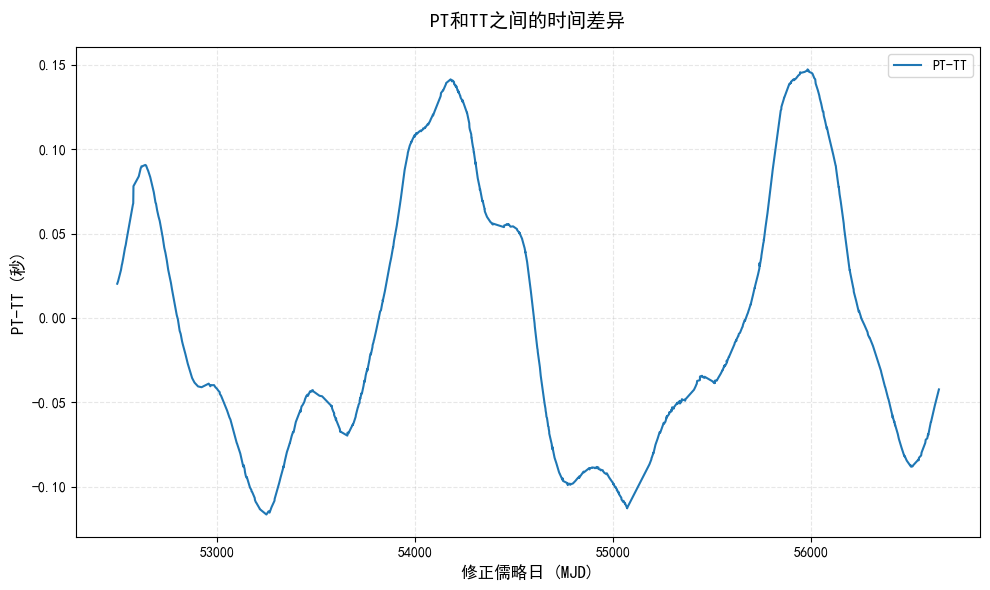

C:\Users\tk\AppData\Local\Temp\ipykernel_28324\2887740068.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\2887740068.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\2887740068.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\2887740068.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituti

正在进行差分进化全局优化...
differential_evolution step 1: f(x)= 1064.417318524082


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


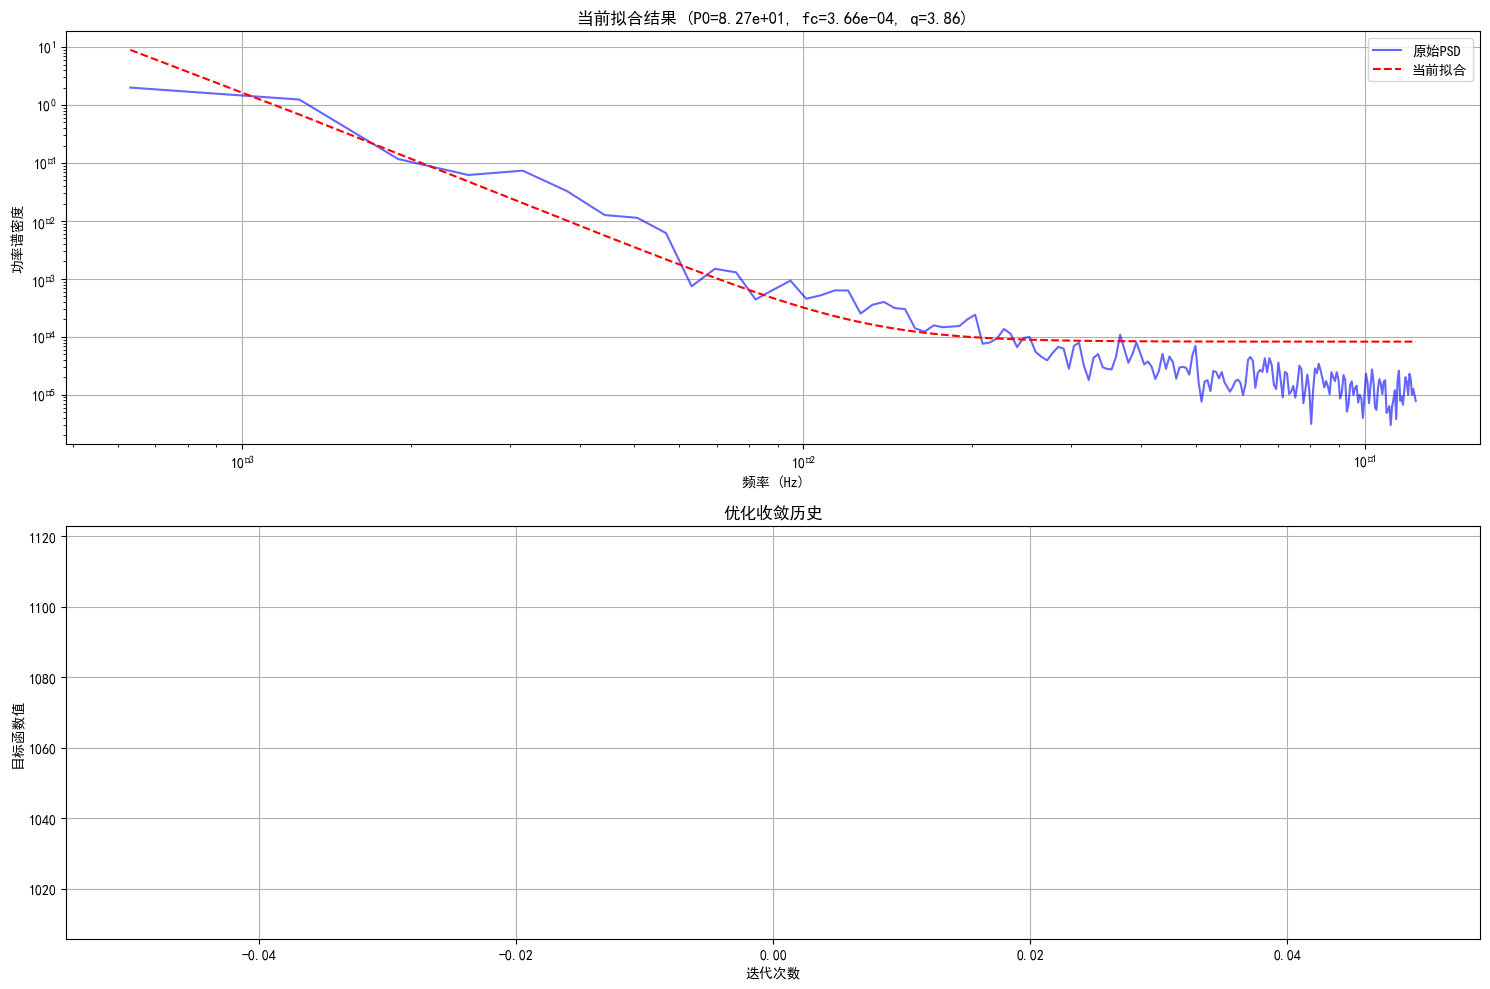

differential_evolution step 2: f(x)= 1064.417318524082


<Figure size 640x480 with 0 Axes>

differential_evolution step 3: f(x)= 1051.2667491612124


<Figure size 640x480 with 0 Axes>

differential_evolution step 4: f(x)= 747.2731612219764


<Figure size 640x480 with 0 Axes>

differential_evolution step 5: f(x)= 599.0458844413281


<Figure size 640x480 with 0 Axes>

differential_evolution step 6: f(x)= 565.711408114288


<Figure size 640x480 with 0 Axes>

differential_evolution step 7: f(x)= 565.711408114288


<Figure size 640x480 with 0 Axes>

differential_evolution step 8: f(x)= 565.711408114288


<Figure size 640x480 with 0 Axes>

differential_evolution step 9: f(x)= 487.0700531832223


<Figure size 640x480 with 0 Axes>

differential_evolution step 10: f(x)= 368.36136636896475


<Figure size 640x480 with 0 Axes>

differential_evolution step 11: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 12: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 13: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 14: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 15: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 16: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 17: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 18: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 19: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 20: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 21: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 22: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 23: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 24: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 25: f(x)= 241.16491021914177


<Figure size 640x480 with 0 Axes>

differential_evolution step 26: f(x)= 236.69113629243225


<Figure size 640x480 with 0 Axes>

differential_evolution step 27: f(x)= 229.28749913680343


<Figure size 640x480 with 0 Axes>

differential_evolution step 28: f(x)= 229.28749913680343


<Figure size 640x480 with 0 Axes>

differential_evolution step 29: f(x)= 229.28749913680343


<Figure size 640x480 with 0 Axes>

differential_evolution step 30: f(x)= 229.28749913680343


<Figure size 640x480 with 0 Axes>

differential_evolution step 31: f(x)= 221.0332925842045


<Figure size 640x480 with 0 Axes>

differential_evolution step 32: f(x)= 219.79818229188038


<Figure size 640x480 with 0 Axes>

differential_evolution step 33: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 34: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 35: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 36: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 37: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 38: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 39: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 40: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 41: f(x)= 218.80408703148453


<Figure size 640x480 with 0 Axes>

differential_evolution step 42: f(x)= 218.62728221586693


<Figure size 640x480 with 0 Axes>

differential_evolution step 43: f(x)= 218.62728221586693


<Figure size 640x480 with 0 Axes>

differential_evolution step 44: f(x)= 218.34917267073857


<Figure size 640x480 with 0 Axes>

Polishing solution with 'L-BFGS-B'

正在进行Nelder-Mead局部优化...


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.



最终拟合结果：
P0 (红噪声强度) = 2.34e+00
fc (转角频率) = 1.10e-03
q (谱指数) = 3.88

最终模型拟合度 (R²): 0.9547
模型拟合度达到95%以上，符合要求。


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


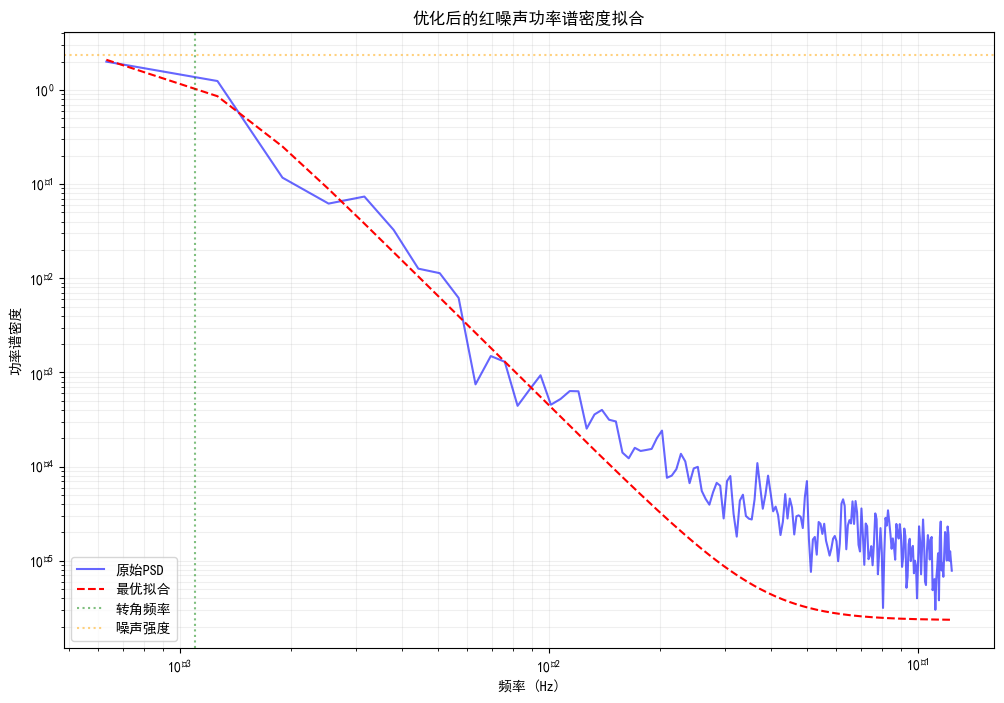

In [6]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution, minimize
from scipy.fft import fft, fftfreq
from scipy import signal
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 从附件加载数据
file_path = r'C:\Users\tk\Desktop\2024“ShuWei Cup”_Problem\code\问题一\Attachment 1.xlsx'  # 文件路径
df = pd.ExcelFile(file_path)  # 读取Excel文件
data = df.parse(sheet_name=0)  # 加载第一个工作表

# 数据清理
cleaned_data = data.iloc[1:, [1, 0]]  # 提取第二列（MJD）和第三列（PT-TT）
cleaned_data.columns = ['MJD', 'PT_TT']  # 重命名列
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['MJD'], errors='coerce').notnull()]  # 去除非数值行
cleaned_data['MJD'] = cleaned_data['MJD'].astype(float)  # 转换为浮点型
cleaned_data['PT_TT'] = cleaned_data['PT_TT'].astype(float)  # 转换为浮点型

# 提取清理后的时间和残差数据
time = cleaned_data['MJD'].values
residuals = cleaned_data['PT_TT'].values

# 创建数据可视化图表
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# 数据去趋势：使用更高阶多项式拟合去除长期趋势
def find_optimal_poly_order(time, residuals, max_order=10):
    """找到最优的多项式拟合阶数"""
    best_r2 = -np.inf
    best_order = 1
    
    for order in range(1, max_order + 1):
        poly_coeff = np.polyfit(time, residuals, order)
        trend = np.polyval(poly_coeff, time)
        r2 = 1 - np.sum((residuals - trend)**2) / np.sum((residuals - np.mean(residuals))**2)
        
        if r2 > best_r2:
            best_r2 = r2
            best_order = order
    
    return best_order

# 使用最优阶数进行拟合
optimal_order = find_optimal_poly_order(time, residuals)
poly_coeff = np.polyfit(time, residuals, optimal_order)
trend = np.polyval(poly_coeff, time)
detrended_residuals = residuals - trend

# 计算残差的功率谱密度
def compute_psd(detrended_residuals, sampling_rate=1):
    N = len(detrended_residuals)
    
    # 增加nperseg和noverlap参数的控制来获得更平滑的PSD估计
    nperseg = min(8192, N//2)  # 增加段长度
    noverlap = nperseg * 3//4  # 增加重叠率
    
    f, psd = signal.welch(detrended_residuals, 
                         fs=sampling_rate, 
                         window='hann',
                         nperseg=nperseg,
                         noverlap=noverlap,
                         detrend='linear')  # 添加线性去趋势
    
    # 只返回正频率部分
    mask = f > 0
    return f[mask], psd[mask]

# 定义功率谱密度（PSD）模型
def power_spectral_density(f, P0, fc, q):
    """
    改进的功率谱密度模型，增加了低频区域的拟合精度
    """
    return P0 / (1 + (f/fc)**q) + P0 * 1e-6  # 添加小偏移量避免零值

# 定义目标函数
def objective_function(params, frequencies, psd_values, freq_mask):
    P0, fc, q = params
    psd_pred = power_spectral_density(frequencies[freq_mask], P0, fc, q)
    y_true_log = np.log10(psd_values[freq_mask])
    y_pred_log = np.log10(psd_pred)
    weights = 1/frequencies[freq_mask]
    return np.sum(weights * (y_true_log - y_pred_log)**2)

# 获取并预处理数据
sampling_rate = 1/(time[1] - time[0])
frequencies, psd_values = compute_psd(detrended_residuals, sampling_rate)

# 设置优化参数范围
freq_mask = frequencies < 1e-2
P0_init = np.mean(psd_values[frequencies < 1e-3])
bounds = [(P0_init*0.01, P0_init*100), (1e-4, 1e-2), (1.0, 4.0)]

# 创建一个图形来实时显示优化过程
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plt.ion()  # 打开交互模式

# 存储优化过程中的参数和目标函数值
optimization_history = []

def callback(xk, convergence=None):
    """回调函数，用于记录和显示优化过程"""
    P0, fc, q = xk
    psd_pred = power_spectral_density(frequencies, P0, fc, q)
    obj_value = objective_function(xk, frequencies, psd_values, freq_mask)
    optimization_history.append((xk, obj_value))
    
    # 清除之前的图形
    ax1.clear()
    ax2.clear()
    
    # 绘制当前拟合结果
    ax1.loglog(frequencies, psd_values, 'b-', label='原始PSD', alpha=0.6)
    ax1.loglog(frequencies, psd_pred, 'r--', label='当前拟合')
    ax1.set_xlabel('频率 (Hz)')
    ax1.set_ylabel('功率谱密度')
    ax1.set_title(f'当前拟合结果 (P0={P0:.2e}, fc={fc:.2e}, q={q:.2f})')
    ax1.grid(True)
    ax1.legend()
    
    # 绘制目标函数收敛历史
    history_values = [h[1] for h in optimization_history]
    ax2.plot(history_values, 'g-')
    ax2.set_xlabel('迭代次数')
    ax2.set_ylabel('目标函数值')
    ax2.set_title('优化收敛历史')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.draw()
    plt.pause(0.1)  # 暂停一小段时间以更新图形

# 使用差分进化算法进行全局优化
print("正在进行差分进化全局优化...")
result_de = differential_evolution(
    objective_function,
    bounds,
    args=(frequencies, psd_values, freq_mask),
    maxiter=100,
    popsize=20,
    mutation=(0.5, 1.0),
    recombination=0.7,
    callback=callback,
    disp=True,
    updating='deferred'  # 使用延迟更新策略
)

# 使用Nelder-Mead算法进行局部优化
print("\n正在进行Nelder-Mead局部优化...")
result_nm = minimize(
    objective_function,
    result_de.x,
    args=(frequencies, psd_values, freq_mask),
    method='Nelder-Mead',
    callback=callback,
    options={'maxiter': 1000}
)

plt.ioff()  # 关闭交互模式

# 获取最终参数
P0, fc, q = result_nm.x

# 打印优化结果
print("\n最终拟合结果：")
print(f"P0 (红噪声强度) = {P0:.2e}")
print(f"fc (转角频率) = {fc:.2e}")
print(f"q (谱指数) = {q:.2f}")

# 绘制最终拟合结果
plt.figure(figsize=(12, 8))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, power_spectral_density(frequencies, P0, fc, q),
          label="最优拟合", color="red", linestyle="--")
plt.axvline(fc, color='green', linestyle=':', alpha=0.5, label='转角频率')
plt.axhline(P0, color='orange', linestyle=':', alpha=0.5, label='噪声强度')
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("优化后的红噪声功率谱密度拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# 计算并显示最终的R²值
def calculate_r_squared(frequencies, y_true, y_pred):
    """在低频区域计算R²"""
    freq_mask = frequencies < 1e-2
    y_true_log = np.log10(y_true[freq_mask])
    y_pred_log = np.log10(y_pred[freq_mask])
    residuals = y_true_log - y_pred_log
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true_log - np.mean(y_true_log))**2)
    return 1 - (ss_res / ss_tot)

psd_fitted = power_spectral_density(frequencies, P0, fc, q)
r_squared = calculate_r_squared(frequencies, psd_values, psd_fitted)
print(f"\n最终模型拟合度 (R²): {r_squared:.4f}")

if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要继续优化。")

plt.show()

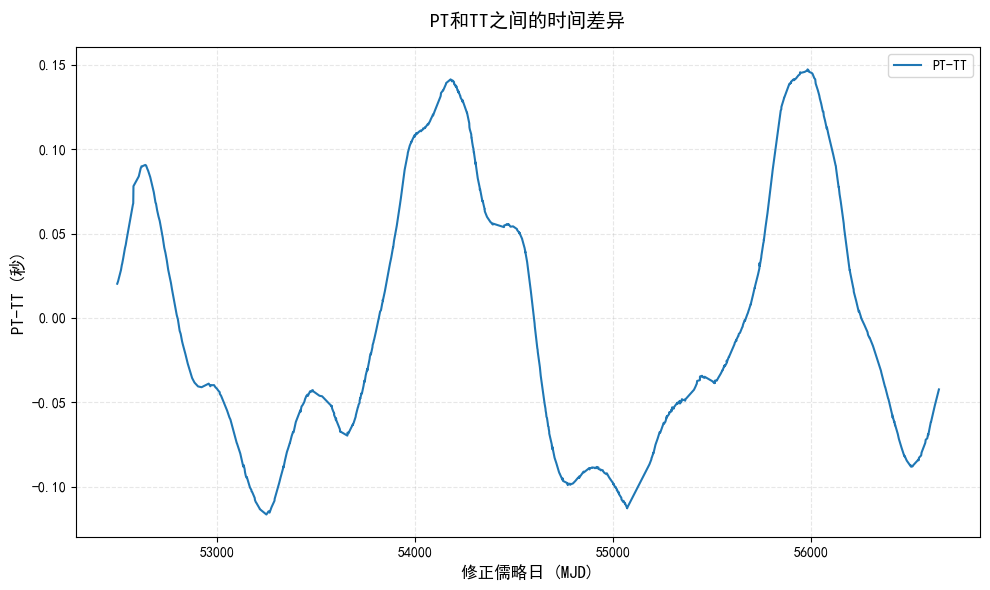


多项式去势结果：
最优多项式阶数: 6
多项式系数 (从高阶到低阶):
x^6 的系数: -8.32e-21
x^5 的系数: 2.68e-15
x^4 的系数: -3.60e-10
x^3 的系数: 2.58e-05
x^2 的系数: -1.04e+00
x^1 的系数: 2.23e+04
x^0 的系数: -1.99e+08


C:\Users\tk\AppData\Local\Temp\ipykernel_28324\220874122.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\220874122.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\220874122.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)
C:\Users\tk\AppData\Local\Temp\ipykernel_28324\220874122.py:48: RankWarning: Polyfit may be poorly conditioned
  poly_coeff = np.polyfit(time, residuals, order)


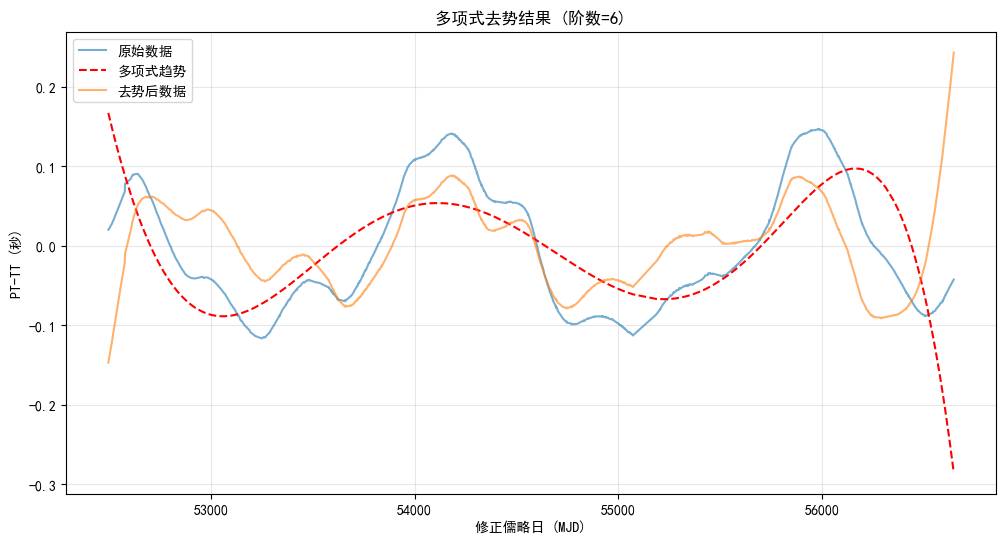


正在进行差分进化全局优化...
differential_evolution step 1: f(x)= 2491.1653139993377
differential_evolution step 2: f(x)= 1845.2911436295433
differential_evolution step 3: f(x)= 799.9178153826306
differential_evolution step 4: f(x)= 799.9178153826306
differential_evolution step 5: f(x)= 716.251981818075
differential_evolution step 6: f(x)= 637.2861819080048
differential_evolution step 7: f(x)= 429.81717412841624
differential_evolution step 8: f(x)= 362.5565511580695
differential_evolution step 9: f(x)= 325.7499909092141
differential_evolution step 10: f(x)= 325.7499909092141
differential_evolution step 11: f(x)= 325.7499909092141
differential_evolution step 12: f(x)= 275.35239750451706
differential_evolution step 13: f(x)= 275.35239750451706
differential_evolution step 14: f(x)= 275.35239750451706
differential_evolution step 15: f(x)= 245.4223081929835
differential_evolution step 16: f(x)= 245.4223081929835
differential_evolution step 17: f(x)= 241.30531288217554
differential_evolution step 18: f(

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

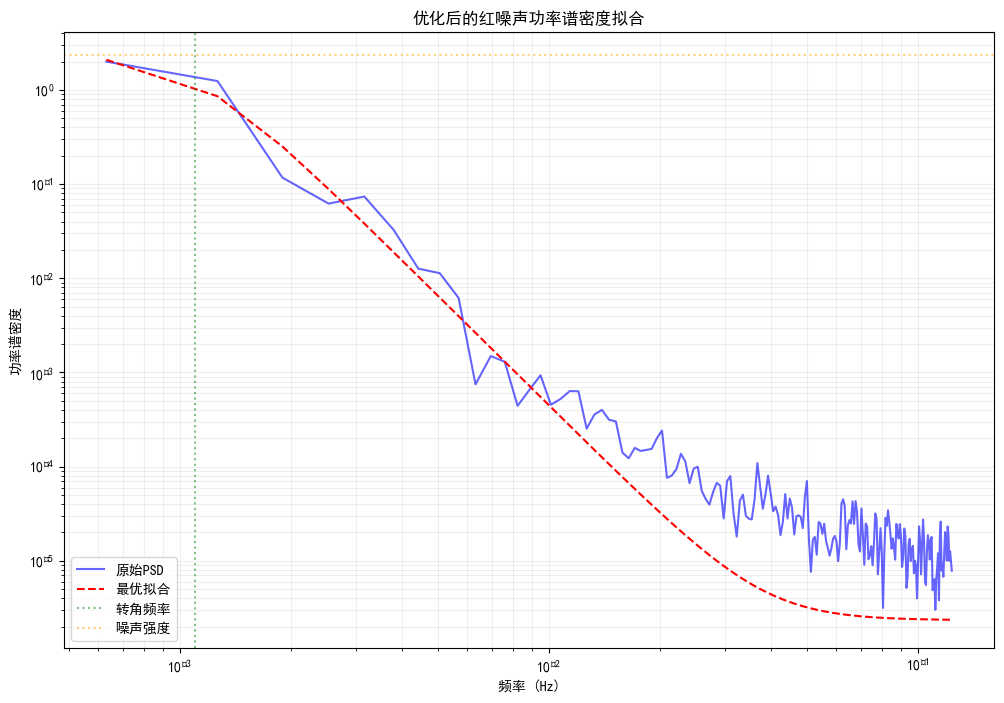

In [5]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution, minimize
from scipy.fft import fft, fftfreq
from scipy import signal
from tqdm import tqdm

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 从附件加载数据
file_path = r'C:\Users\tk\Desktop\2024“ShuWei Cup”_Problem\code\问题一\Attachment 1.xlsx'  # 文件路径
df = pd.ExcelFile(file_path)  # 读取Excel文件
data = df.parse(sheet_name=0)  # 加载第一个工作表

# 数据清理
cleaned_data = data.iloc[1:, [1, 0]]  # 提取第二列（MJD）和第三列（PT-TT）
cleaned_data.columns = ['MJD', 'PT_TT']  # 重命名列
cleaned_data = cleaned_data[pd.to_numeric(cleaned_data['MJD'], errors='coerce').notnull()]  # 去除非数值行
cleaned_data['MJD'] = cleaned_data['MJD'].astype(float)  # 转换为浮点型
cleaned_data['PT_TT'] = cleaned_data['PT_TT'].astype(float)  # 转换为浮点型

# 提取清理后的时间和残差数据
time = cleaned_data['MJD'].values
residuals = cleaned_data['PT_TT'].values

# 创建数据可视化图表
plt.figure(figsize=(10, 6), facecolor='white')
plt.plot(time, residuals, label='PT-TT', color='#1f77b4', linewidth=1.5)
plt.xlabel('修正儒略日 (MJD)', fontsize=12)
plt.ylabel('PT-TT (秒)', fontsize=12)
plt.title('PT和TT之间的时间差异', fontsize=14, pad=15)
plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(frameon=True, fontsize=10)
plt.tight_layout()
plt.show()

# 数据去趋势：使用更高阶多项式拟合去除长期趋势
def find_optimal_poly_order(time, residuals, max_order=10):
    """找到最优的多项式拟合阶数"""
    best_r2 = -np.inf
    best_order = 1
    
    for order in range(1, max_order + 1):
        poly_coeff = np.polyfit(time, residuals, order)
        trend = np.polyval(poly_coeff, time)
        r2 = 1 - np.sum((residuals - trend)**2) / np.sum((residuals - np.mean(residuals))**2)
        
        if r2 > best_r2:
            best_r2 = r2
            best_order = order
    
    return best_order

# 使用最优阶数进行拟合
optimal_order = find_optimal_poly_order(time, residuals)
poly_coeff = np.polyfit(time, residuals, optimal_order)
trend = np.polyval(poly_coeff, time)
detrended_residuals = residuals - trend

# 打印多项式去势的阶数和系数
print(f"\n多项式去势结果：")
print(f"最优多项式阶数: {optimal_order}")
print("多项式系数 (从高阶到低阶):")
for i, coef in enumerate(poly_coeff):
    print(f"x^{optimal_order-i} 的系数: {coef:.2e}")

# 可视化去势结果
plt.figure(figsize=(12, 6))
plt.plot(time, residuals, label='原始数据', alpha=0.6)
plt.plot(time, trend, label='多项式趋势', color='red', linestyle='--')
plt.plot(time, detrended_residuals, label='去势后数据', alpha=0.6)
plt.xlabel('修正儒略日 (MJD)')
plt.ylabel('PT-TT (秒)')
plt.title(f'多项式去势结果 (阶数={optimal_order})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 计算残差的功率谱密度
def compute_psd(detrended_residuals, sampling_rate=1):
    N = len(detrended_residuals)
    
    # 增加nperseg和noverlap参数的控制来获得更平滑的PSD估计
    nperseg = min(8192, N//2)  # 增加段长度
    noverlap = nperseg * 3//4  # 增加重叠率
    
    f, psd = signal.welch(detrended_residuals, 
                         fs=sampling_rate, 
                         window='hann',
                         nperseg=nperseg,
                         noverlap=noverlap,
                         detrend='linear')  # 添加线性去趋势
    
    # 只返回正频率部分
    mask = f > 0
    return f[mask], psd[mask]

# 定义功率谱密度（PSD）模型
def power_spectral_density(f, P0, fc, q):
    """
    改进的功率谱密度模型，增加了低频区域的拟合精度
    """
    return P0 / (1 + (f/fc)**q) + P0 * 1e-6  # 添加小偏移量避免零值

# 定义目标函数
def objective_function(params, frequencies, psd_values, freq_mask):
    P0, fc, q = params
    psd_pred = power_spectral_density(frequencies[freq_mask], P0, fc, q)
    y_true_log = np.log10(psd_values[freq_mask])
    y_pred_log = np.log10(psd_pred)
    weights = 1/frequencies[freq_mask]
    return np.sum(weights * (y_true_log - y_pred_log)**2)

# 获取并预处理数据
sampling_rate = 1/(time[1] - time[0])
frequencies, psd_values = compute_psd(detrended_residuals, sampling_rate)

# 设置优化参数范围
freq_mask = frequencies < 1e-2
P0_init = np.mean(psd_values[frequencies < 1e-3])
bounds = [(P0_init*0.01, P0_init*100), (1e-4, 1e-2), (1.0, 4.0)]

# 使用差分进化算法进行全局优化
print("\n正在进行差分进化全局优化...")
result_de = differential_evolution(
    objective_function,
    bounds,
    args=(frequencies, psd_values, freq_mask),
    maxiter=100,
    popsize=20,
    mutation=(0.5, 1.0),
    recombination=0.7,
    disp=True,
    updating='deferred'
)

# 使用Nelder-Mead算法进行局部优化
print("\n正在进行Nelder-Mead局部优化...")
result_nm = minimize(
    objective_function,
    result_de.x,
    args=(frequencies, psd_values, freq_mask),
    method='Nelder-Mead',
    options={'maxiter': 1000}
)

# 获取最终参数
P0, fc, q = result_nm.x

# 打印优化结果
print("\n最终拟合结果：")
print(f"P0 (红噪声强度) = {P0:.2e}")
print(f"fc (转角频率) = {fc:.2e}")
print(f"q (谱指数) = {q:.2f}")

# 绘制最终拟合结果
plt.figure(figsize=(12, 8))
plt.loglog(frequencies, psd_values, label="原始PSD", color="blue", alpha=0.6)
plt.loglog(frequencies, power_spectral_density(frequencies, P0, fc, q),
          label="最优拟合", color="red", linestyle="--")
plt.axvline(fc, color='green', linestyle=':', alpha=0.5, label='转角频率')
plt.axhline(P0, color='orange', linestyle=':', alpha=0.5, label='噪声强度')
plt.xlabel("频率 (Hz)")
plt.ylabel("功率谱密度")
plt.title("优化后的红噪声功率谱密度拟合")
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)

# 计算并显示最终的R²值
def calculate_r_squared(frequencies, y_true, y_pred):
    """在低频区域计算R²"""
    freq_mask = frequencies < 1e-2
    y_true_log = np.log10(y_true[freq_mask])
    y_pred_log = np.log10(y_pred[freq_mask])
    residuals = y_true_log - y_pred_log
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true_log - np.mean(y_true_log))**2)
    return 1 - (ss_res / ss_tot)

psd_fitted = power_spectral_density(frequencies, P0, fc, q)
r_squared = calculate_r_squared(frequencies, psd_values, psd_fitted)
print(f"\n最终模型拟合度 (R²): {r_squared:.4f}")

if r_squared >= 0.95:
    print("模型拟合度达到95%以上，符合要求。")
else:
    print("模型拟合度未达到95%，需要继续优化。")

plt.show()